In [1]:
import geopandas as gpd
import numpy as np

import pandas as pd

from osgeo import gdal, ogr, osr
from gdalconst import *
gdal.UseExceptions()

import rasterio

import stac

## Obter imagens da área de interesse via STAC (BrazilDataCube)

In [2]:
# Criar conexão com o servidor da STAC
bdc_stac_service = stac.STAC('http://brazildatacube.dpi.inpe.br/')

# Obter itens filtrados pelo objeto JSON (https://stacspec.org/STAC-api.html#operation/postSearchSTAC)
# Filtro: 200 primeiras imagens da coleção 'LC8SR-1' que intersectam o ponto (-46.872, -17.150).
item = bdc_stac_service.search({'collections':['LC8SR-1'], 
                                "intersects": {"type": "Point",
                                               "coordinates": [-46.872, -17.150]},
                                'limit': 200})

# Mostrar quantas imagens foram recuperadas
len(item.features)

93

## Criar um dicionário com as datas e links das imagens

In [3]:
links = {}

# Percorrer todos o itens obtidos ds STAC
for i in item.features:
    
    # Adquirir a data da imagem
    date = i['properties']['datetime'][0:10]
    
    # Inserir um item no dicionário 'links' com (chave = data da imagem) e (valor = URL da imagem).
    # IV selecionado: NDVI
    links[date] = i['assets']['sr_ndvi']['href']

# Mostrar dicionário de links
links

{'2020-08-26': 'http://brazildatacube.dpi.inpe.br/Repository/Archive/LC8SR/2020-08/220072/LC08_L1TP_220072_20200826_20200905_01_T1_sr_ndvi.tif',
 '2020-08-10': 'http://brazildatacube.dpi.inpe.br/Repository/Archive/LC8SR/2020-08/220072/LC08_L1TP_220072_20200810_20200821_01_T1_sr_ndvi.tif',
 '2020-07-25': 'http://brazildatacube.dpi.inpe.br/Repository/Archive/LC8SR/2020-07/220072/LC08_L1TP_220072_20200725_20200807_01_T1_sr_ndvi.tif',
 '2020-07-09': 'http://brazildatacube.dpi.inpe.br/Repository/Archive/LC8SR/2020-07/220072/LC08_L1TP_220072_20200709_20200721_01_T1_sr_ndvi.tif',
 '2020-06-23': 'http://brazildatacube.dpi.inpe.br/Repository/Archive/LC8SR/2020-06/220072/LC08_L1TP_220072_20200623_20200707_01_T1_sr_ndvi.tif',
 '2020-06-07': 'http://brazildatacube.dpi.inpe.br/Repository/Archive/LC8SR/2020-06/220072/LC08_L1TP_220072_20200607_20200625_01_T1_sr_ndvi.tif',
 '2020-05-22': 'http://brazildatacube.dpi.inpe.br/Repository/Archive/LC8SR/2020-05/220072/LC08_L1TP_220072_20200522_20200607_01_T1

## Abrir arquivo de pontos e extrair coordenadas

In [4]:
# Abrir arquivo de pontos
df = gpd.read_file('./DADOS/pt_inicial_10qtd.geojson')

# Gerar duas listas (lat e lon) com as coordenadas dos pontos
lat = []
lon = []
for i in df.geometry:
    lon.append(i.x)
    lat.append(i.y)

## Amostrar os valores das imagens para os pontos obtidos

A célula abaixo amostra os valores de todas as imagens (93) para todos o pontos (1094). Para isso ela precisa abrir cada uma como dataset e processá-la a partir de todos os pontos definidos (93 x 1094). 

A sua execução demanda mais tempo que as demais (aprx. 20 min).

In [5]:
# Para evitar a execução dessa célula, salvei o resultado dela (dicionário) em um arquivo. 
# Caso o arquivo seja encontrado, o processamento é evitado
try:
    out = np.load('./DADOS/out.npy', allow_pickle=True).item()
    print("Arquivo aberto com sucesso!")
except:
    print("Arquivo não encontrado, amostrando pontos pela série de imagens...")
    
    # Criar um dicionário de saída
    out = {}
    # Percorrer todas os pares data(k)/URL(v) da lista 'links'
    for k,v in links.items():
        # Abrir a imagem da URL
        with rasterio.open(v) as src:
            # Obter o valores dos pixel da imagem para as coordenadas dos pontos (amostrar valores)
            val = [x for x in src.sample(zip(lon,lat))]

            # Transformar cada item (array unitario) da lista 'val' para número
            for i in range(len(val)):
                val[i] = val[i][0]

            # Inserir o item no dicionário 'out' com (chave = data da imagem) e (valor = lista de valores da imagem).
            out[k] = val
                    
    print("Amostragem finalizada!")
    
    try:
        np.save('./DADOS/out.npy', out)
        print('O resultado foi salvo')
    except:
        print('O resultado não foi salvo')

Arquivo não encontrado, amostrando pontos pela série de imagens...
Amostragem finalizada!
O resultado foi salvo


In [6]:
# Inserir os valores obtidos como colunas no dataframe dos pontos
for k,v in out.items():
    df.insert(loc=2,column=k,value=v)

# Agrupar os pontos de cada pivo a partir da média (e excluir a coluna 'id')
df = df.groupby(['PIVOID']).mean().drop('id',1)

In [7]:
df

,2016-08-15,2016-08-31,2016-09-16,2016-10-02,2016-10-18,2016-11-03,2016-11-19,2016-12-05,2016-12-21,2017-01-06,...,2020-04-04,2020-04-20,2020-05-06,2020-05-22,2020-06-07,2020-06-23,2020-07-09,2020-07-25,2020-08-10,2020-08-26
PIVOID,,,,,,,,,,,,,,,,,,,,,
1,2294.0,2066.2,2225.4,2324.4,2878.1,671.4,2828.2,716.3,4371.0,4268.8,...,8709.6,459.3,1979.4,7123.2,4753.8,3927.5,3576.0,3459.9,3464.9,3419.9
2,5372.0,2662.5,4559.6,5635.0,6375.0,669.1,1720.4,555.3,4531.0,7102.1,...,4640.3,421.9,1371.2,7464.5,7336.3,6896.7,6564.3,5968.6,5600.2,5532.8
3,3620.7,3301.4,3581.7,4757.1,4188.9,271.6,1749.7,536.9,4914.2,8971.3,...,5247.7,279.7,1548.4,8538.2,8404.8,7375.5,5774.5,4881.8,4569.6,4042.2
4,2446.9,2177.5,2184.4,2072.8,2770.9,286.6,3678.8,425.1,5072.8,4459.2,...,711.0,445.0,1937.9,8494.4,9072.1,8916.2,8702.3,7650.3,6431.9,5528.9
5,3220.1,2876.3,2706.7,2893.1,3098.8,505.6,1644.7,459.2,5237.0,7932.0,...,6981.7,305.8,1859.5,8468.6,8095.0,6142.5,4143.4,2835.5,2730.0,2637.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1089,2430.9,2859.4,1266.1,2842.7,2370.2,2514.3,2739.9,261.3,4615.9,4064.3,...,4211.6,2414.0,762.3,5287.9,5677.5,6937.3,5431.7,5072.5,3268.8,3659.4
1090,2065.8,4354.6,1753.0,3525.2,4702.2,5302.9,5301.9,125.8,6475.1,7171.1,...,3397.0,4251.4,792.1,4691.6,3137.6,3062.2,3005.9,2943.1,2847.1,2270.0
1091,2405.3,4052.1,1728.8,4744.5,4355.2,1710.2,2412.1,238.7,5212.5,4765.8,...,6024.3,216.2,410.3,4002.1,5820.4,6991.4,7073.9,6988.4,4535.6,3504.4


## Selecionar 6 pivôs aleatoriamente e plotar as suas respectivas séries

A cada execução da célula abaixo são sorteados 6 pivos diferentes

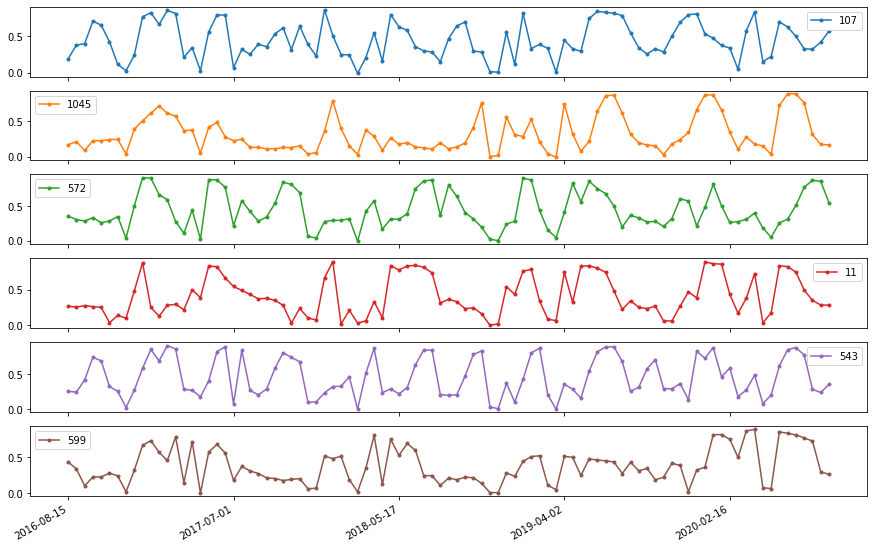

In [13]:
# Selecionar 6 pivôs aleatoriamente, transpor o dataframe e converter o valores para o intervalo [0,1] (divisão por 10000)
df_reduzido = df.sample(6).T/10000
# Plotar as séries
df_reduzido.plot(subplots=True, figsize=(15,10), marker='.');